In [138]:
import torch
from torch import nn
from torchvision.models import alexnet
from torchvision import transforms
import h5py
import skimage.transform
import matplotlib.pyplot as pl
from torch.utils.data import Dataset, DataLoader
from scipy.stats import wasserstein_distance
from scipy.spatial import distance,distance_matrix

In [69]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
        )
        self.relu=nn.ReLU()
        self.output = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        it = self.classifier(x)
        it_relu=self.relu(it)
        x = self.output(it_relu)
        return x,it,it_relu

In [70]:
alexnet_it = AlexNet(num_classes=10)
alex_pretrained = alexnet(pretrained=True)

In [71]:
alexnet_it.load_state_dict(alex_pretrained.state_dict(),strict=False)

_IncompatibleKeys(missing_keys=['output.weight', 'output.bias'], unexpected_keys=['classifier.6.weight', 'classifier.6.bias'])

In [11]:
data=h5py.File('E://dataset.h5','r')

In [83]:
# data_img = skimage.transform.resize(data['images'],output_shape=(1320,3,224,224))

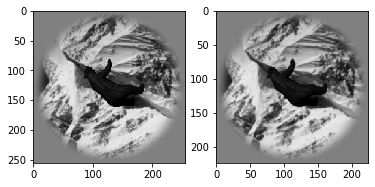

In [52]:
fig,ax=pl.subplots(1,2)
ax[0].imshow(data['images'][0].transpose(1,2,0).astype('int'))
ax[1].imshow(data_img.transpose(1,2,0).astype('int'))

In [101]:
class KarDataset(Dataset):
    def __init__(self, data,resize=True,transform=None):
        self.data = data
        self.resize = resize
        self.transform = transform
        self.total_len = len(data['images'])

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.total_len:
            raise Exception("index out of range")

        x = self.data['images'][idx]
        if self.resize:
            x = skimage.transform.resize(x,output_shape=(3,224,224))
        y = self.data['obj'][0][idx]

        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)
 
        return x, y

In [117]:
test_dataset = KarDataset(data,transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1,shuffle=False,pin_memory=True)

In [112]:
it_result = torch.zeros(1320,4096)
it_relu_result = torch.zeros(1320,4096)

In [122]:
for i,(k,v) in enumerate(test_loader):
        if i%100==0:
            print(f'{i}')
        c,it,it_relu=alexnet_it(k.float())
        it_result[i] = it.detach().clone()
        it_relu_result[i] = it_relu.detach().clone()

i
i
i
i
i
i
i
i
i
i
i
i
i
i


In [142]:
dist_mat=distance_matrix(it_relu_result.detach().numpy(),it_relu_result.detach().numpy())

In [ ]:
%matplotlib qt5
pl.imshow(dist_mat)
pl.colorbar()